### Import modules

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import simpeg.electromagnetics.time_domain as tdem

from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
    inversion,
)

from simpeg.data_misfit import L2DataMisfit

import discretize
from discretize import TensorMesh

In [6]:
from function import (
    plot_sounding,
    get_sounding_df
)

In [227]:
def plot_data(data_obj):
    plt.loglog(LM_times, -data_obj[src_lm, rx_lm])
    plt.loglog(HM_times, -data_obj[src_hm, rx_hm])
    
    plt.loglog(
        LM_times, -data_container[src_lm, rx_lm], color='C0', marker='x', linestyle=""
    )
    plt.loglog(
        HM_times, -data_container[src_hm, rx_hm], color='C1', marker='x', linestyle=""
    )

### Load data from .csv

In [8]:
#please download data from "release" on the repository and rename the file_path below

file_path = "../../flight_line_101102_101201.csv"
file_path_all_data = "../../AusAEM_WA_Block_E_EM.csv"

df = pd.read_csv(file_path, 
                 delimiter=",") 

df_all = pd.read_csv(file_path_all_data, 
                 delimiter=",") 

# Replace invalid values (-99999999) with NaN
df.replace(-99999999, np.nan, inplace=True)
df.replace(0, np.nan, inplace=True)
# Drop rows with missing values
df.dropna(inplace=True)

/var/folders/nv/3rmg65wj733gdy4gk5sxm8cc0000gn/T/ipykernel_2763/1952385971.py:9: DtypeWarning: Columns (153,154,156,171) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(file_path_all_data,


In [85]:
# input flight line number and sounding ID
# 101102 or 101201
flightline = 101102 # or 101201

# 0 - 7420 for flight line 101102 
# 7421 - 16261 for flight line 101201
sounding = 7300 #7300

station, station_lm_data, station_hm_data, station_lm_std, station_hm_std = get_sounding_df(flightline, sounding, df)

### Survey (Sounding-Independent)

1. Gate centre times

In [123]:
# load the gate opening time for LM and HM respectively
LM_excel = "../../LM_times.csv"
HM_excel = "../../HM_times.csv"
LM_times_csv = pd.read_csv(LM_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 
HM_times_csv = pd.read_csv(HM_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 

In [126]:
# extract gate_centre (s)
LM_times = LM_times_csv["Gate Centre (s)"].to_numpy()
HM_times = HM_times_csv["Gate Centre (s)"].to_numpy()

2. Waveform

In [117]:
LM_waveform_excel = "../../LM_waveform.csv"
HM_waveform_excel = "../../HM_waveform.csv"
LM_waveform_csv = pd.read_csv(LM_waveform_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 
HM_waveform_csv = pd.read_csv(HM_waveform_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 

In [119]:
# extract the time and form from waveform_csv 
LM_wave_time = LM_waveform_csv["Time (s)"]
LM_wave_form = LM_waveform_csv["Amplitude"]
HM_wave_time = HM_waveform_csv["Time (s)"]
HM_wave_form = HM_waveform_csv["Amplitude"]

3. Transmitter and Receiver Location

In [101]:
# shape of the transmitter, and the offset of the receiver coil.
tx_shape = np.array([[-12.64,  -2.13,   0.  ],
                     [ -6.15,  -8.59,   0.  ],
                     [  5.74,  -8.59,   0.  ],
                     [ 11.13,  -3.19,   0.  ],
                     [ 11.13,   3.19,   0.  ],
                     [  5.74,   8.59,   0.  ],
                     [ -6.15,   8.59,   0.  ],
                     [-12.64,   2.13,   0.  ],
                     [-12.64,  -2.13,   0.  ]])
rx_offset = np.array([-13.46,   0.  ,  -2.  ]) # from data processing report

tx_area=342.0 # from data processing report

### Mesh Setup

In [138]:
# map
exp_map = maps.ExpMap()
exp_map * np.array([-5])

array([0.00673795])

In [721]:
# (start_size, number_of_cells, expansion_factor)
h = [1, (1.0, 39, 1.10)]
mesh = discretize.TensorMesh([h,])
mesh

TensorMesh: 40 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     40          0.00        442.59      1.00     41.14    1.10

### Inversion

In [724]:
# 0 - 7420 for flight line 101102 
# 7421 - 16261 for flight line 101201
sounding_list = [7350,7225,7100,6975] #,6850,6725,6600,6450,6325,6200,5975,5850,5625,5500] #[7350]#[7400,7300,7200,7100,7000]
# Initialize an empty list to store the data
data_list = []

In [725]:
# Pre-define parameters outside the loop that don't change
m_0 = np.log(1E-2)  # sigma = 1E-2 S/m
minimizer_params = {
    'maxIter': 10, 
    'maxIterLS': 20, 
    'maxIterCG': 10, 
    'tolCG': 1e-3
}

# Create a single instance of shared objects
empty_reg = regularization.Smallness(discretize.TensorMesh([1]))
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
save_dict = directives.SaveOutputDictEveryIteration()

In [728]:
# Process soundings
for i in sounding_list:
    try:
        # Extract sounding data
        station, station_lm_data, station_hm_data, station_lm_std, station_hm_std = get_sounding_df(flightline, i, df)
        
        # add UTM coordinates to transmitter shape and the receiver offset
        tx_loc = tx_shape + [station["Easting"].iloc[0], station["Northing"].iloc[0], station["Frame_Height"].iloc[0]]
        rx_loc = rx_offset + [station["Easting"].iloc[0], station["Northing"].iloc[0], station["Frame_Height"].iloc[0]]
        
        # Define source for survey input
        # Low moment:
        rx_lm = tdem.receivers.PointMagneticFluxTimeDerivative(rx_loc, LM_times, orientation='z')
        lm_wave = tdem.sources.PiecewiseLinearWaveform(LM_wave_time, LM_wave_form)
        src_lm = tdem.sources.LineCurrent(rx_lm, tx_loc, waveform=lm_wave)
        
        # high moment
        rx_hm = tdem.receivers.PointMagneticFluxTimeDerivative(rx_loc, HM_times, orientation='z')
        hm_wave = tdem.sources.PiecewiseLinearWaveform(HM_wave_time, HM_wave_form)
        src_hm = tdem.sources.LineCurrent(rx_hm, tx_loc, waveform=hm_wave)
        
        # Define survey
        srv = tdem.Survey([src_lm, src_hm])
        
        # Observed data (normalised) & relative errors 
        dobs = -tx_area * np.r_[station_lm_data, station_hm_data]
        rel_err = np.r_[station_lm_std, station_hm_std]
        data_container = data.Data(srv, dobs=dobs, relative_error=rel_err)
        
        # Halfspace Inversion
        #m_0 = np.log(1E-2)  # sigma = 1E-2 S/m
        sim_inv_halfspace = tdem.Simulation1DLayered(srv, sigmaMap=exp_map)
        phi_d_halfspace = L2DataMisfit(data=data_container, simulation=sim_inv_halfspace)
        minimizer = optimization.InexactGaussNewton(maxIter=15, maxIterLS=20, maxIterCG=10, tolCG=1e-3)
        #empty_reg = regularization.Smallness(discretize.TensorMesh([1]))
        inv_prob_halfspace = inverse_problem.BaseInvProblem(phi_d_halfspace, reg=empty_reg, opt=minimizer, beta=0.0)
        inv_halfspace = inversion.BaseInversion(inv_prob_halfspace, [])
        recovered_model = inv_halfspace.run(m_0)
        
        # Inversion Setup
        sim_reg = tdem.Simulation1DLayered(srv, sigmaMap=exp_map, thicknesses=mesh.h[0][:-1])
        phi_d_reg = L2DataMisfit(data=data_container, simulation=sim_reg)
        reg = regularization.WeightedLeastSquares(mesh)
        m_0_reg = np.full(mesh.n_cells, recovered_model[0])
        minimizer_reg = optimization.InexactGaussNewton(maxIter=15, maxIterLS=20, maxIterCG=10, tolCG=1e-3)
        inv_prob_3 = inverse_problem.BaseInvProblem(phi_d_reg, reg=reg, opt=minimizer_reg)
        #beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
        #save_dict = directives.SaveOutputDictEveryIteration()
        inv3 = inversion.BaseInversion(inv_prob_3, [save_dict, beta_schedule])
        recovered_model_3 = inv3.run(m_0_reg)
        
        # Calculate predicted data
        data_pred_3 = sim_reg.dpred(recovered_model_3)
        
        # Extract L-curve information
        n_iter = save_dict.opt.iter
        phi_ds = [save_dict.outDict[i]['phi_d'] for i in range(1, n_iter)]
        phi_ms = [save_dict.outDict[i]['phi_m'] for i in range(1, n_iter)]
        betas = [save_dict.outDict[i]['beta'] for i in range(1, n_iter)]
        
        # Collect data for the current sounding
        data_list.append({
            'Sounding': i,
            'Easting': station["Easting"].iloc[0],
            'Northing': station["Northing"].iloc[0],
            'DTM_AHD': station["DTM_AHD"].iloc[0],
            'Thicknesses': sim_reg.thicknesses.copy(),
            'Sigma': sim_reg.sigma.copy(),
            'Recovered_Model': recovered_model_3.copy(),
            'Predicted_Data': data_pred_3,
            'Halfspace_Conductivity': sim_inv_halfspace.sigma,
            'Observed_Data': dobs,
            # L-curve information
            'Phi_d': phi_ds,
            'Phi_m': phi_ms,
            'Betas': betas,
            'N_iterations': n_iter
        })
        
    except Exception as e:
        print(f"Error processing sounding {i}: {e}")
        continue


Running inversion with SimPEG v0.22.2
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  7.52e+06  0.00e+00  7.52e+06    5.23e+06      0              
   1  0.00e+00  3.97e+06  1.25e+00  3.97e+06    4.91e+06      0              
   2  0.00e+00  3.56e+06  9.33e-01  3.56e+06    7.05e+05      0              
   3  0.00e+00  3.55e+06  8.79e-01  3.55e+06    8.98e+04      0   Skip BFGS  
   4  0.00e+00  3.55e+06  8.72e-01  3.55e+06    1.11e+04      0   Skip BFGS  
   5  0

/Applications/anaconda3/envs/simpeg-env/lib/python3.9/site-packages/simpeg/directives/directives.py:320: UserWarning: InversionDirective SaveOutputDictEveryIteration has switched to a new inversion.
  d.inversion = i
/Applications/anaconda3/envs/simpeg-env/lib/python3.9/site-packages/simpeg/directives/directives.py:320: UserWarning: InversionDirective BetaSchedule has switched to a new inversion.
  d.inversion = i


   0  1.00e+00  1.97e+06  0.00e+00  1.97e+06    1.33e+06      0              
   1  1.00e+00  1.81e+06  2.55e+01  1.81e+06    2.22e+06      3              
   2  1.00e+00  1.58e+06  6.63e+01  1.58e+06    2.63e+06      3   Skip BFGS  
   3  5.00e-01  9.64e+05  2.42e+02  9.65e+05    2.72e+06      1   Skip BFGS  
   4  5.00e-01  7.84e+05  4.01e+02  7.84e+05    3.68e+06      0   Skip BFGS  
   5  5.00e-01  1.69e+05  3.63e+02  1.69e+05    1.70e+06      0   Skip BFGS  
   6  2.50e-01  2.44e+04  3.15e+02  2.45e+04    4.91e+05      0   Skip BFGS  
   7  2.50e-01  2.43e+04  3.17e+02  2.44e+04    4.95e+05      6              
   8  2.50e-01  2.43e+04  3.19e+02  2.43e+04    4.98e+05      7   Skip BFGS  
   9  1.25e-01  2.42e+04  3.21e+02  2.42e+04    5.01e+05      7   Skip BFGS  
  10  1.25e-01  2.41e+04  3.22e+02  2.42e+04    5.03e+05      7   Skip BFGS  
  11  1.25e-01  2.40e+04  3.24e+02  2.41e+04    5.05e+05      7   Skip BFGS  
  12  6.25e-02  2.39e+04  3.25e+02  2.39e+04    5.06e+05      7 

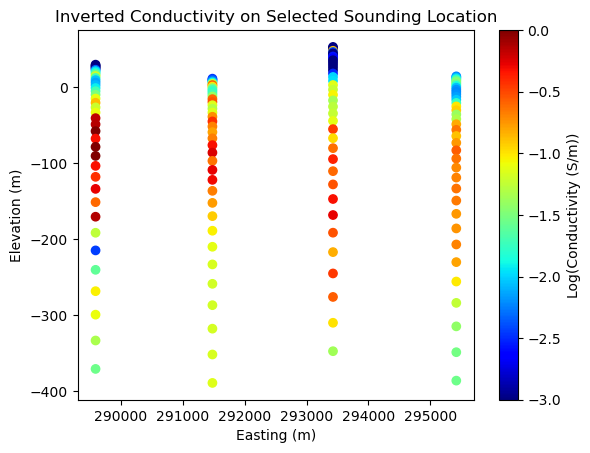

In [734]:
# Initialize lists to store cumulative thicknesses and sigma values
easting_list = []
elevation_list = []
depth_list = []
sigma_list = []
Recovered_Model_list = []
#Synthetic_Data_list = []
Halfspace_Conductivity_list = []
Predicted_Data_list = []
DTM_AHD_list = []

# Process each entry in the data
for entry in data_list:
    easting = entry['Easting']
    thicknesses = entry['Thicknesses']
    sigma = entry['Sigma'] #* 0.01
    Recovered_Model = entry['Recovered_Model']
    #Synthetic_Data = entry['Synthetic_Data']
    Halfspace_Conductivity = entry['Halfspace_Conductivity']
    Predicted_Data = entry['Predicted_Data']
    DTM_AHD = entry['DTM_AHD']
    
    # Calculate cumulative thicknesses (depths)
    cumulative_thicknesses = np.cumsum(thicknesses)

    # Ensure the lengths match
    min_length = min(len(cumulative_thicknesses), len(sigma))
    cumulative_thicknesses = cumulative_thicknesses[:min_length]
    sigma = sigma[:min_length]

    # Calculate elevation by subtracting depth from topography (DTM_AHD)
    elevation = DTM_AHD - cumulative_thicknesses
    
    # Append values to lists
    easting_list.extend([easting] * len(elevation))
    elevation_list.extend(elevation)
    depth_list.extend(cumulative_thicknesses)
    sigma_list.extend(sigma)
    Recovered_Model_list.append(Recovered_Model)
    Synthetic_Data_list.append(Synthetic_Data)
    Halfspace_Conductivity_list.append(Halfspace_Conductivity)
    Predicted_Data_list.append(Predicted_Data)
    DTM_AHD_list.append(DTM_AHD)

# Create a scatter plot with sigma in log scale and set color bar range
sc = plt.scatter(easting_list, elevation_list, c=np.log10(sigma_list), cmap='jet', vmin=-3, vmax=0)
cbar = plt.colorbar(sc)
cbar.set_label('Log(Conductivity (S/m))')
plt.xlabel('Easting (m)')
plt.ylabel('Elevation (m)')
plt.title('Inverted Conductivity on Selected Sounding Location')
#plt.gca().invert_yaxis()  # Invert y-axis to have depth increasing downwards
plt.show()

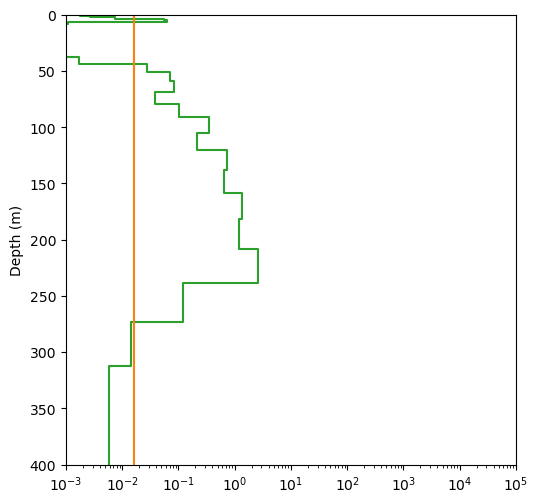

In [693]:
# Function to plot a specific sounding
def plot_sounding(index):
    entry = data_list[index]
    thicknesses = entry['Thicknesses']
    sigma = entry['Sigma']
    recovered_model = entry['Recovered_Model']
    #synthetic_data = entry['Synthetic_Data']
    halfspace_conductivity = entry['Halfspace_Conductivity']
    
    # Generate synthetic data
    data_pre_3 = synthetic_data
    
    # Plot the 1D layer model
    ax = plot_1d_layer_model(thicknesses, sigma, color='C2')
    ax.axvline(halfspace_conductivity, color='C1')
    ax.set_ylim([400, 0])
    ax.set_xlim([1E-3, 1E5])
    plt.show()

# Specify which sounding to plot (0, 1, or 2)
plot_sounding(2)  # Plot sounding 0
# plot_sounding(1)  # Plot sounding 1
# plot_sounding(2)  # Plot sounding 2


In [669]:
def plot_dpred(index):
    entry = data_list[index]
    recovered_model = entry['Recovered_Model']
    data_pre_3 = sim_reg.make_synthetic_data(recovered_model)

    # Plot the 1D layer model
    ax = plot_data(data_pre_3)
    plt.show()

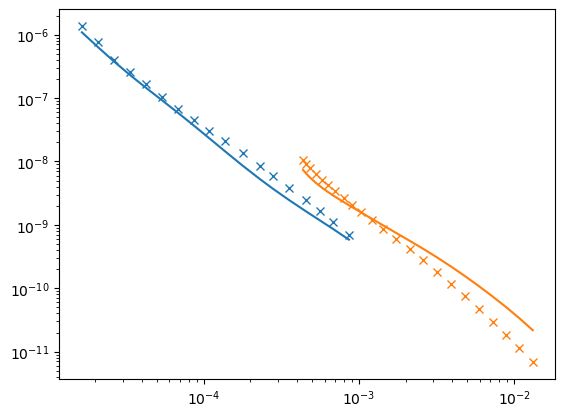

In [685]:
plot_dpred(0)

In [673]:
# Function to plot a specific sounding
def plot_phim_phid(index):
    entry = data_list[index]
    phids = entry['Phi_d']
    phims = entry['Phi_m']
    n_iter = entry['N_iterations']
    betas = entry['Betas']

    # Plot phim_phid
    plt.loglog(phims, phids)
    plt.loglog(phi_ms[8], phi_ds[8], marker='*', markersize=10)
    plt.show()

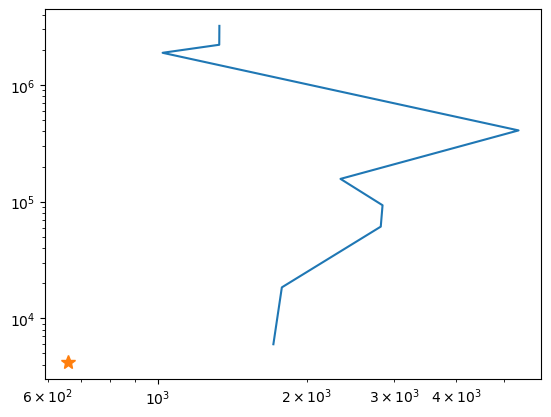

In [679]:
plot_phim_phid(0)